In [107]:
import pandas as pd
import numpy as np
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

In [108]:
# read in the data
df = pd.read_csv("./../data/supervised_1_1.csv")

In [109]:
print(df.shape)
df.set_index('date', inplace=True)
df.head()

(7115050, 20)


,e5gas,weekday,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,total,rotterdam,brent,wti,eurusd,vehicles,state,station,num_days
date,,,,,,,,,,,,,,,,,,,
2014-05-16,1.536647,5,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622837,109.424042,101.258553,1.369886,15211.0,10,0,0
2014-05-17,1.564000,6,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622486,109.699997,101.669998,1.369580,9146.0,10,0,1
2014-05-18,1.569417,0,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622136,109.699997,101.669998,1.369580,9843.0,10,0,2
2014-05-19,1.578167,1,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.621785,109.838928,102.008537,1.370161,13502.0,10,0,3
2014-05-20,1.599000,2,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.620475,109.522926,102.058907,1.368282,12876.0,10,0,4


In [110]:
# try removing the averages so as to not include endogenous variables on the rigth hand side
df.drop(['eurusd', 'vehicles'], axis=1, inplace=True)
print(df.shape)
df.head()

(7115050, 17)


,e5gas,weekday,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,total,rotterdam,brent,wti,state,station,num_days
date,,,,,,,,,,,,,,,,,
2014-05-16,1.536647,5,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622837,109.424042,101.258553,10,0,0
2014-05-17,1.564000,6,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622486,109.699997,101.669998,10,0,1
2014-05-18,1.569417,0,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622136,109.699997,101.669998,10,0,2
2014-05-19,1.578167,1,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.621785,109.838928,102.008537,10,0,3
2014-05-20,1.599000,2,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.620475,109.522926,102.058907,10,0,4


In [111]:
# replace the oil prices for the last 30 days with the predictions
oil = pd.read_csv('./../data/linear_oil_yhat.csv')

last_30 = ['2015-11-12', '2015-11-13', '2015-11-14', '2015-11-15', '2015-11-16', '2015-11-17', '2015-11-18',
          '2015-11-19', '2015-11-20', '2015-11-21', '2015-11-22', '2015-11-23', '2015-11-24', '2015-11-25',
          '2015-11-26', '2015-11-27', '2015-11-28', '2015-11-29', '2015-11-30', '2015-12-01', '2015-12-02',
          '2015-12-03', '2015-12-04', '2015-12-05', '2015-12-06', '2015-12-07', '2015-12-08', '2015-12-09',
          '2015-12-10', '2015-12-10']

for index, date in enumerate(last_30):
    df.loc[date, 'rotterdam'] = oil['rot_yhat'][index]
    df.loc[date, 'brent'] = oil['brent_yhat'][index]
    df.loc[date, 'wti'] = oil['wti_yhat'][index]

In [112]:
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = pd.DataFrame(scaler.fit_transform(values))
# frame as supervised learning
n_seq = 1
reframed.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.398580,0.833333,0.499847,0.451308,0.231638,0.0,0.0,0.0,0.0,0.0,0.0,0.837361,0.930292,0.921895,0.384615,0.0,0.000000
1,0.415691,1.000000,0.499847,0.451308,0.231638,0.0,0.0,0.0,0.0,0.0,0.0,0.836386,0.933953,0.927822,0.384615,0.0,0.001742
2,0.419080,0.000000,0.499847,0.451308,0.231638,0.0,0.0,0.0,0.0,0.0,0.0,0.835411,0.933953,0.927822,0.384615,0.0,0.003484
3,0.424554,0.166667,0.499847,0.451308,0.231638,0.0,0.0,0.0,0.0,0.0,0.0,0.834437,0.935795,0.932700,0.384615,0.0,0.005226
4,0.437586,0.333333,0.499847,0.451308,0.231638,0.0,0.0,0.0,0.0,0.0,0.0,0.830794,0.931604,0.933425,0.384615,0.0,0.006969


In [113]:
# split into train and test sets
# now order needs to be by day rather than by station -- reorder by num_days
# num_days is 16 and 15 is station
reframed.sort_values(by=[16, 15], inplace=True)

# let's try training on only 100 days
# day_130 = reframed[16].unique()[-130]
# print(day_130)
# reframed = reframed.loc[reframed[16] > day_130]

# and here is where we remove the last 30 days
day_30 = reframed[16].unique()[-30]
print(day_30)
train = reframed.loc[reframed[16] < day_30]
test = reframed.loc[reframed[16] >= day_30]

0.9494773745536804


In [114]:
n_seq = 1
train_values = train.values
test_values = test.values
# split into input and outputs
train_X, train_y = train_values[:, n_seq:], train_values[:, :n_seq]
test_X, test_y = test_values[:, n_seq:], test_values[:, :n_seq]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6743830, 1, 16) (6743830, 1) (371220, 1, 16) (371220, 1)


Train on 6743830 samples, validate on 371220 samples
Epoch 1/20
 - 64s - loss: 0.0158 - val_loss: 0.0177
Epoch 2/20
 - 62s - loss: 0.0132 - val_loss: 0.0163
Epoch 3/20
 - 61s - loss: 0.0129 - val_loss: 0.0158
Epoch 4/20
 - 59s - loss: 0.0127 - val_loss: 0.0156
Epoch 5/20
 - 60s - loss: 0.0125 - val_loss: 0.0154
Epoch 6/20
 - 58s - loss: 0.0124 - val_loss: 0.0152
Epoch 7/20
 - 61s - loss: 0.0124 - val_loss: 0.0150
Epoch 8/20
 - 61s - loss: 0.0123 - val_loss: 0.0147
Epoch 9/20
 - 61s - loss: 0.0123 - val_loss: 0.0144
Epoch 10/20
 - 57s - loss: 0.0122 - val_loss: 0.0142
Epoch 11/20
 - 61s - loss: 0.0122 - val_loss: 0.0140
Epoch 12/20
 - 59s - loss: 0.0121 - val_loss: 0.0139
Epoch 13/20
 - 59s - loss: 0.0121 - val_loss: 0.0139
Epoch 14/20
 - 59s - loss: 0.0121 - val_loss: 0.0138
Epoch 15/20
 - 59s - loss: 0.0121 - val_loss: 0.0138
Epoch 16/20
 - 59s - loss: 0.0120 - val_loss: 0.0139
Epoch 17/20
 - 58s - loss: 0.0120 - val_loss: 0.0139
Epoch 18/20
 - 61s - loss: 0.0120 - val_loss: 0.0139
Ep

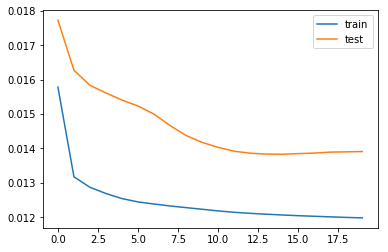

In [115]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(n_seq))
model.compile(loss='mae', optimizer='adam')
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=2, mode='auto')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=1000, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[es])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [117]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 0:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhats = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 0:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_ys = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_ys, inv_yhats))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.030


* 50 neurons, 10 epochs, 7200 batch size, 1 layer (1): 0.032
* 50 neurons, 15 epochs, 7200 batch size, 1 layer (1): 0.032
* 50 neurons, 1 epochs, 7200 batch size, 1 layer (1): 0.032
* 50 neurons, 1 epochs, 1000 batch size, 1 layer (1): 0.034
* 50 neurons, 10 epochs, 1000 batch size, 1 layer (1): 0.031
* 50 neurons, 15 epochs, 1000 batch size, 1 layer (1): 0.031
* 50 neurons, 10 epochs, 1000 batch size, 2 layers (10,1): 0.037
* 50 neurons, 10 epochs, 3000 batch size, 1 layer (1): 0.032
* 50 neurons, 10 epochs, 900 batch size, 1 layer (1): 0.032
* 50 neurons, 10 epochs, 500 batch size, 1 layer (1): 0.33
* 50 neurons, 5 epochs, 1000 batch size, 1 layer (1): 0.33
* 50 neurons, 20 epochs, 1000 batch size, 1 layer (1): 0.030
* 50 neurons, 30 epochs, 1000 batch size, 1 layer (1): 0.030
* 50 neurons, 30 epochs, 10000 batch size, 1 layer (1): 0.036
* 50 neurons, 40 epochs, 1000 batch size, 1 layer (1): 0.031
* 50 neurons, 100 epochs, 1000 batch size, 1 layer (1): 0.032
* 50 neurons, 500 epochs, 1000 batch size, 1 layer (1):

Smaller data size:
* 50 neurons, 50 epochs, 1000 batch size, 1 layer (1): 0.031
* 50 neurons, 60 epochs, 1000 batch size, 1 layer (1): 0.032
* 50 neurons, 60 epochs, 500 batch size, 1 layer (1): 0.031
* 50 neurons, 70 epochs, 500 batch size, 1 layer (1): 0.031
* 50 neurons, 80 epochs, 500 batch size, 1 layer (1): 0.030
* 50 neurons, 90 epochs, 500 batch size, 1 layer (1): 0.031

Early Stopping
SMALL
* 50 neurons, 90 epochs, 500 batch size, 1 layer (1), 2 patience: 0.033
* 50 neurons, 90 epochs, 500 batch size, 1 layer (1), 5 patience: 0.034
* 50 neurons, 90 epochs, 500 batch size, 1 layer (1), 20 patience: 0.036
* 50 neurons, 100 epochs, 500 batch size, 1 layer (1), 40 patience: 0.032
* 50 neurons, 100 epochs, 500 batch size, 1 layer (1), 50 patience: 0.030 (epoch 100)

FULL
* 50 neurons, 500 epochs, 1000 batch size, 1 layer (1), 5 patience: 0.30 (epoch 27)
* 50 neurons, 20 epochs, 1000 batch size, 1 layer (1), 5 patience: 0.30 (epoch 20)

Dropout

More Layers

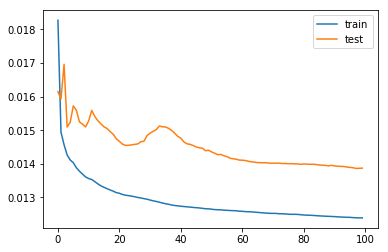

In [101]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [118]:
from bokeh.plotting import figure, output_file, show

output_file("line.html")

p = figure(plot_width=400, plot_height=400)
p.yaxis.axis_label = 'Root Mean Squared Error'
p.xaxis.axis_label = 'Epoch'

# add a line renderer
p.line(range(1,101), history.history['loss'], line_width=2, color='navy', legend='Train Loss')
p.line(range(1,101), history.history['val_loss'], line_width=2, color='orange', legend='Test Loss')

show(p)

/usr/local/anaconda3/lib/python3.6/site-packages/bokeh/models/sources.py:137: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('x', 100), ('y', 20)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))
/usr/local/anaconda3/lib/python3.6/site-packages/bokeh/models/sources.py:137: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('x', 100), ('y', 20)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


In [116]:
# small 100
best_y = inv_y
best_yhat = inv_yhat

In [119]:
# each day to make a graph of the error
ob = pd.DataFrame(inv_y)
pred = pd.DataFrame(inv_yhat)
pred[15] = round(pred[15])
pred[16] = round(pred[16])

In [120]:
rmse_days = []
days = []
for i in range(545,575):
    c_ob = ob[ob[16] == i][0]
    c_pred = pred[pred[16] == i][0]
    rmse_days.append(sqrt(mean_squared_error(c_ob, c_pred)))
    days.append(i)
    

In [121]:
rmse_days
days_df = pd.DataFrame()
days_df['rmse'] = rmse_days
days_df['date'] = last_30
days_df['date'] = pd.to_datetime(days_df['date'])

In [124]:
from bokeh.plotting import figure, output_file, show

output_file("line.html")

p = figure(plot_width=400, plot_height=400, x_axis_type='datetime')
p.yaxis.axis_label = 'Root Mean Squared Error'

# add a line renderer
p.line(days_df['date'], days_df['rmse'], line_width=2, color='#DD4968')

show(p)